<center>
<h1> Introduction to NLP | ASSIGNMENT 1 </h1>
<h2> Author : Soumodipta Bose</h2>
<h3>
Roll No. : 2021201086
</h3>
</center>

In [1]:
import tokenizer as tk
import argparse
import os
import pickle
import numpy as np
import time
import math
import matplotlib.pyplot as plt
ROLL_NO = "2021201086"


def decorate():
    print("=================================================================================================")

def error(msg):
    decorate()
    print("[ERROR] : " + msg)



def info(msg):
    decorate()
    print("[INFO] : " + msg)

# def prod(values):
#     p = float(1)
#     for v in values:
#         p = p * v
#     return p

class Ngram:
    def __init__(self):
        pass

    def get_ngram(self, text_line, n):
        text_line = text_line.strip()
        ngram = []
        tokens = text_line.split(' ')
        if len(tokens) == 0:
            return None
        tokens = ["<BEGIN>" for _ in range(n-2)] + tokens
        for i in range(len(tokens)-n+1):
            ngram.append(" ".join(tokens[i:i+n]))
        return ngram

    def __generate_ngram_table(self, text_lines, n):
        """
        <ngram> : {
            <history> : {
                <history 1>: { <current 1>: <freq>, <current 2>: <freq>, ...},
                <history 2>: { <current 1>: <freq>, <current 2>: <freq>, ...},
                ...
            }
            <current> :{
                <current 1>: { <history 1>, <history 2> ...},
                <current 2>: { <history 1>, <history 2> ...},
                ...
            }
        }
        """

        freq_table = {}
        current_table = {}
        unique_tokens = set()
        for text in text_lines:
            ngram = self.get_ngram(text, n)
            if ngram is not None:
                for token in ngram:
                    unique_tokens.add(token)
                    history = " ".join(token.split(" ")[:-1])
                    current = token.split(" ")[-1]
                    if history not in freq_table:
                        freq_table[history] = {}
                        freq_table[history]["<total>"] = 0
                    if current in freq_table[history]:
                        freq_table[history][current] += 1
                        freq_table[history]["<total>"] += 1
                    else:
                        freq_table[history][current] = 1
                        freq_table[history]["<total>"] += 1

                    if current not in current_table:
                        current_table[current] = set()
                    else:
                        current_table[current].add(history)

        return {"<history>":freq_table,"<current>":current_table,"<total>":len(unique_tokens)}

    def construct_freq_table(self, text_lines, n, threshold=10):
        freq_table = {}
        for k in range(1, n+1):
            freq_table[k] = self.__generate_ngram_table(text_lines, k)
        # freq_table[1]["<history>"]['']["<#>"] = 0
        # freq_table[1]["<current>"]["<#>"]=set()
        # key_set = list(freq_table[1]["<history>"][''].keys())
        # for key in key_set:
        #     if freq_table[1]["<history>"][''][key] < threshold:
        #         freq_table[1]["<history>"]['']["<#>"] += freq_table[1]["<history>"][''][key]
        #         freq_table[1]["<history>"][''].pop(key)
        #         freq_table[1]["<current>"].pop(key)
        # freq_table[1]["<total>"] = len(freq_table[1]["<history>"][''])
        # freq_table[1]["<history>"]['']["<total>"]=len(freq_table[1]["<history>"][''])
        return freq_table


class Smoothing:
    def __init__(self):
        pass

    def get_perplexity(self, model, test_data):
        pass


class NgramModel:
    def __init__(self, n):
        self.n = n
        self.ngram = Ngram()
        self.cache = {}
        self.ngram_table = {}

    def is_ngram_present(self,n,ngram):
        history = " ".join(ngram.split(" ")[:-1])
        current = ngram.split(" ")[-1]
        try :
            _ = self.ngram_table[n]["<history>"][history][current]
            return True
        except KeyError:
            return False

    def count_size(self,n):
        return self.ngram_table[n]["<total>"]

    def get_ngram_freq(self,n, ngram):
        # return self.ngram_table[n][ngram]
        return self.count_ngram_freq(ngram)

    def count_ngram_freq(self, ngram):
        # freq count( ngram)
        tokens =ngram.split(" ")
        gram = len(tokens)
        history = " ".join(tokens[:-1])
        current = ngram.split(" ")[-1]
        # if len(tokens) > 0:
        #     if history in self.ngram_table[gram]:
        #         if current in self.ngram_table[gram][history]:
        #             return self.ngram_table[gram][history][current]
        try:
            return self.ngram_table[gram]["<history>"][history][current]
        except KeyError:
            return 0
    def count_ngram_history_freq(self,history):
        if history == "":
            return self.ngram_table[1]["<total>"]
        gram = len(history.split(" "))+1
        return self.ngram_table[gram]["<history>"][history]["<total>"]
    def count_ngram_history(self,history):
        gram = len(history.split(" "))+1
        return len(self.ngram_table[gram]["<history>"][history])

    def count_ngram_current(self,gram,current):
        # total = 0
        # for key in self.ngram_table[gram]:
        #     if key.endswith(current):
        #         total += 1
        return len(self.ngram_table[gram]["<current>"][current])

    def train(self, train_data):
        self.ngram_table = self.ngram.construct_freq_table(train_data, self.n)

    def get_perplexity(self, test_sentence, smoothing: Smoothing):
        perplexity_scores = []
        ngram_tokens = self.ngram.get_ngram(test_sentence, self.n)
        for token in ngram_tokens:
            score = smoothing.get_perplexity(self, token)
            perplexity_scores.append(score)
        N = len(ngram_tokens)
        prod_val =np.prod(perplexity_scores)
        if prod_val == 0:
            prod_val=1e-300
        perplexity_score = pow(1/prod_val, 1/N)
        return perplexity_score



class WittenBell(Smoothing):
    def __init__(self):
        super().__init__()

    def __P_wb(self,model: NgramModel,n, history,current):
        # Probability of current word given history
        if n == 1:
            if model.is_ngram_present(n,"".join(history,current)):
                return model.get_ngram_freq(n,current)/model.count_size(n)
            return 1/len(model.ngram_table[1])
        try:
            LAMBDA = model.count_ngram_history(history)/(
                model.count_ngram_history(history) +model.count_ngram_history_freq(history)
            )
        except:
            new_history = " ".join(history.split(" ")[1:])
            return self.__P_wb(model,n-1,new_history,current)
        P_mle = model.count_ngram_freq(history+" "+current)/model.count_ngram_history_freq(history)
        new_history = " ".join(history.split(" ")[1:])
        P_backoff = self.__P_wb(model,n-1,new_history,current)
        return LAMBDA*P_mle + (1-LAMBDA)*P_backoff

    def get_perplexity(self, model: NgramModel, ngram_token):
        tokens = ngram_token.split(" ")
        history= " ".join(tokens[:-1])
        current = tokens[-1]
        return self.__P_wb(model,len(tokens),history,current)


class KneserNey(Smoothing):
    def __init__(self):
        super().__init__()
        self.d=0.75

    def get_lambda(self,model: NgramModel,n, history):
        if n == 1:
            return self.d/model.count_size(1)
        new_history = " ".join(history.split(" ")[:-1])
        new_current = history.split(" ")[-1]
        try:
            LAMBDA = (self.d/model.count_ngram_history_freq(new_history))*model.count_ngram_history(new_history)
        except:
            return self.d
        return LAMBDA
        
    def __P_kn(self,model: NgramModel,n, history,current,higher_order=False,d=0.75):
        ngram = " ".join([history,current])
        # Probability of current word given history
        if n == 1:
             if not model.is_ngram_present(1,current):
                return d/model.count_size(1)
             return model.get_ngram_freq(1,current)/model.count_size(1)
        if not model.is_ngram_present(n,ngram):
            new_history =" ".join(history.split(" ")[1:])
            return self.__P_kn(model,n-1,new_history,current)
        try:
            if higher_order:
                FIRST_TERM =max(model.count_ngram_freq(ngram)-d,0)/model.count_ngram_history_freq(history)
            else:
                FIRST_TERM =max(model.count_ngram_current(n,current) - d,0)/model.count_size(n)
        except:
            FIRST_TERM = 0
        LAMBDA = self.get_lambda(model,n,history)
        new_history =" ".join(history.split(" ")[1:])
        SECOND_TERM = self.__P_kn(model,n-1,new_history,current)
        return FIRST_TERM + LAMBDA * SECOND_TERM


    def get_perplexity(self, model: NgramModel, ngram_token):
        tokens = ngram_token.split(" ")
        history= " ".join(tokens[:-1])
        current = tokens[-1]
        return self.__P_kn(model,len(tokens),history,current,True)


def test_train_split(data, test_distribution=0.2, flag=False):
    test_size = 1000
    if flag:
        test_size = n*test_distribution
    #seq =int(time.time())
    seq = 12
    np.random.seed(seq)
    n = len(data)
    idx_list = np.random.choice(n, int(test_size), replace=False)
    train_data = []
    test_data = []
    for i in range(len(data)):
        if i in idx_list:
            test_data.append(data[i])
        else:
            train_data.append(data[i])
    return train_data, test_data


In [2]:
smoothing_technique = "k"
CORPUS_PATH = "./corpora/Ulysses - James Joyce.txt"
N = 4

In [3]:

corpus_name = CORPUS_PATH.split("/")[-1].split(".")[0]
if not os.path.exists(CORPUS_PATH):
    error('Corpus file does not exist.')
    exit(1)
CLEAN_CORPORA_PATH = os.path.join("clean_corpora", corpus_name+".txt")
clean_text_lines = []
if not os.path.exists(CLEAN_CORPORA_PATH):
    error('Clean corpus file does not exist.')
    info('Creating clean corpus file.')
    tokenizer = tk.Tokenizer()
    text_lines = tk.read_from_file(CORPUS_PATH)
    clean_text_lines = []
    for text in text_lines:
        clean_text_line = tokenizer.tokenize(text)
        if clean_text_line.strip() != "":
            clean_text_lines.append(clean_text_line)
    tk.save_to_file(CLEAN_CORPORA_PATH, clean_text_lines)
    info('Clean corpus file created.')
else:
    clean_text_lines = tk.load_from_file(CLEAN_CORPORA_PATH)
info('loading clean corpus file.')
train, test = test_train_split(clean_text_lines)
MODEL_PATH = os.path.join(".", "models", ROLL_NO+"_"+corpus_name+".pkl")
if not os.path.exists(MODEL_PATH):
    info('Creating Ngram Model using training data.')
    model = NgramModel(N)
    model.train(train)
    with open(MODEL_PATH, 'wb') as f:
        pickle.dump(model, f)
    info('Ngram model created.')
else:
    info('Loading Ngram model.')
    with open(MODEL_PATH, 'rb') as f:
        model = pickle.load(f)
info('Ngram model loaded.')
LM = input("Enter the name for score TXT file (for which LM): ")
if smoothing_technique == "k":
    k = KneserNey()
    info('Calculating perplexity using KneserNey smoothing for training data.')
    perplexity_scores_train = []
    PERPLEXITY_SCORE_TRAIN_PATH = os.path.join(".", "scores", ROLL_NO+"_LM"+LM+"_train-perplexity.txt")
    with open(PERPLEXITY_SCORE_TRAIN_PATH, 'w') as f:
        for text in train:
            perplexity_score = model.get_perplexity(text, k)
            perplexity_scores_train.append(perplexity_score)
            # info(text.strip() + " :: " + str(perplexity_score))
            f.write(text.strip() + " :: " + str(perplexity_score) +"\n")
        f.write("Average Perplexity for training data: " + str(np.mean(perplexity_scores_train)))
    info('Perplexity calculated for training data. Saving to file.')
    info ('Average Perplexity for training data: ' + str(np.mean(perplexity_scores_train)))
    info('Calculating perplexity using KneserNey smoothing for testing data.')
    PERPLEXITY_SCORE_TEST_PATH = os.path.join(".", "scores", ROLL_NO+"_LM"+LM+"_test-perplexity.txt")
    perplexity_scores_test =[]
    with open(PERPLEXITY_SCORE_TEST_PATH, 'w') as f:
        for text in test:
            perplexity_score = model.get_perplexity(text, k)
            perplexity_scores_test.append(perplexity_score)
            # info(text.strip() + " :: " + str(perplexity_score))
            f.write(text.strip() + ":: " + str(perplexity_score) +"\n")
        f.write("Average Perplexity for test data: " + str(np.mean(perplexity_scores_test)))
    info('Perplexity calculated. Saved to file.')
    info ('Average Perplexity for test data: ' + str(np.mean(perplexity_scores_test)))

elif smoothing_technique == "w":
    w = WittenBell()
    info('Calculating perplexity using Witten Bell smoothing for training data.')
    perplexity_scores_train = []
    PERPLEXITY_SCORE_TRAIN_PATH = os.path.join(".", "scores", ROLL_NO+"_LM"+LM+"_train-perplexity.txt")
    with open(PERPLEXITY_SCORE_TRAIN_PATH, 'w') as f:
        for text in train:
            perplexity_score = model.get_perplexity(text, w)
            perplexity_scores_train.append(perplexity_score)
            # info(text.strip() + " :: " + str(perplexity_score))
            f.write(text.strip() + " :: " + str(perplexity_score) +"\n")
        f.write("Average Perplexity for training data: " + str(np.mean(perplexity_scores_train)))
    info('Perplexity calculated for training data. Saving to file.')
    info ('Average Perplexity for training data: ' + str(np.mean(perplexity_scores_train)))
    info('Calculating perplexity using Witten Bell smoothing for test data.')
    PERPLEXITY_SCORE_TEST_PATH = os.path.join(".", "scores", ROLL_NO+"_LM"+LM+"_test-perplexity.txt")
    perplexity_scores_test =[]
    i=1
    with open(PERPLEXITY_SCORE_TEST_PATH, 'w') as f:
        for text in test:
            perplexity_score = model.get_perplexity(text, w)
            perplexity_scores_test.append(perplexity_score)
            # print(str(i) + " :: " + str(perplexity_score))
            f.write(text.strip() + ":: " + str(perplexity_score) +"\n")
        f.write("Average Perplexity for test data: " + str(np.mean(perplexity_scores_test)))
    info('Perplexity calculated. Saved to file.')
    info ('Average Perplexity for test data: ' + str(np.mean(perplexity_scores_test)))
    
else:
    error("Incorrect smoothing technique.")
    exit(1)

[INFO] : loading clean corpus file.
[INFO] : Loading Ngram model.
[INFO] : Ngram model loaded.
[INFO] : Calculating perplexity using KneserNey smoothing for training data.
[INFO] : Perplexity calculated for training data. Saving to file.
[INFO] : Average Perplexity for training data: 11.40898474055722
[INFO] : Calculating perplexity using KneserNey smoothing for testing data.
[INFO] : Perplexity calculated. Saved to file.
[INFO] : Average Perplexity for test data: 95.36384708902624


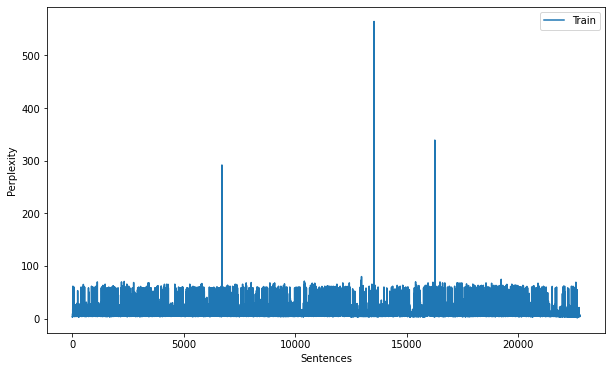

In [8]:
# plot perplexity of train and test data with legends and labels
plt.plot(perplexity_scores_train, label="Train")
#plt.plot(perplexity_scores_test, label="Test")
# increase the plot diagram size
plt.rcParams["figure.figsize"] = (15, 8)
plt.xlabel("Sentences")
plt.ylabel("Perplexity")
plt.legend()
plt.show()

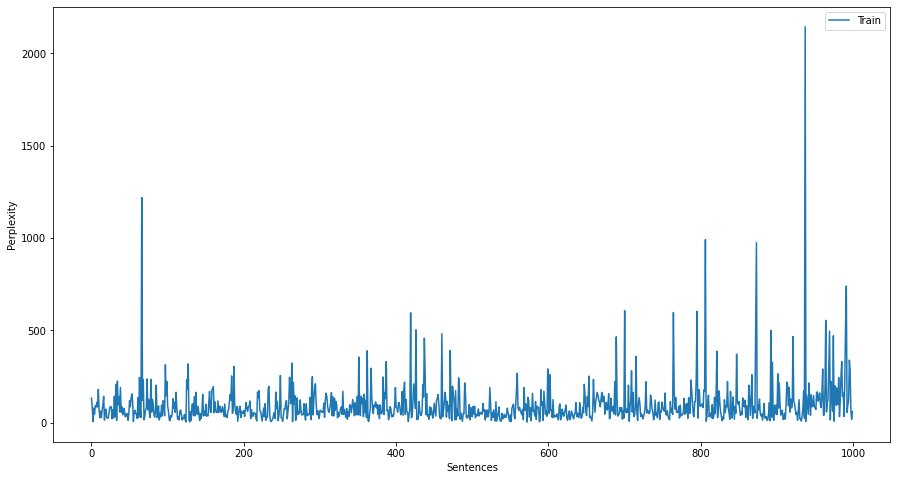

In [9]:
# plot perplexity of train and test data with legends and labels
plt.plot(perplexity_scores_test, label="Train")
#plt.plot(perplexity_scores_test, label="Test")
# increase the plot diagram size
plt.rcParams["figure.figsize"] = (15, 8)
plt.xlabel("Sentences")
plt.ylabel("Perplexity")
plt.legend()
plt.show()